In [ ]:
import numpy as np

N=2500
df =4
def data_generator(n, df):
    data = np.abs(np.random.standard_t(df, size=n))
    return (data - np.mean(data)) / np.std(data)

data = data_generator(N, df)
v = np.std(data)*np.std(data)
print(v)


1.0


In [17]:
df = 4
2*1*np.sqrt(df/np.pi) * (gamma((df+1)/2)/(gamma(df/2)*(df-1)))

1.0

In [15]:
print(2*1*np.sqrt(df/np.pi))

2.256758334191025


In [18]:
print(gamma((df+1)/2)/(gamma(df/2)*(df-1)))

0.443113462726379


In [19]:
print(0.443113462726379*2.256758334191025)

1.0


In [24]:
np.sqrt(  df/(df-2) - (4*df)/(np.pi*(df-1)**2) * (gamma((df+1)/2)/gamma(df/2))**2  )

1.0

In [23]:
df/(df-2) - (4*df)/(np.pi*(df-1)**2) * (gamma((df+1)/2)/gamma(df/2))**2

1.0

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import gamma

def data_generator(n, df):
    data = np.abs(np.random.standard_t(df, size=n))
    return (data - mean_theo) / std_theo



def estimator(N, k, O, df):
    # Generate data
    data = data_generator(N, df)
    #true_mean = np.mean(data)

    # Adding outliers
    if O > 0:
        replace_indices = np.random.choice(N, O, replace=False)
        data[replace_indices] = x0

    groups = np.array_split(data, k)
    mu_bar = np.array([np.mean(g) for g in groups])
    sigma_hat = np.array([np.std(g, ddof=1) for g in groups])

    # Calculate mu_MOM
    mu_MOM = np.median([np.mean(g) for g in groups])

    # Calculate mu_hat_N_1
    alpha = (1 / sigma_hat**1) / np.sum(1 / sigma_hat**1)
    mu_hat_N_1 = np.sum(alpha * mu_bar)

    # Calculate mu_hat_N_2
    alpha = (1 / sigma_hat**2) / np.sum(1 / sigma_hat**2)
    mu_hat_N_2 = np.sum(alpha * mu_bar)

    # Calculate mu_Trim
    epsilon = O / N
    trimmed_data = np.sort(data)[
        (np.floor(epsilon * N) + 5).astype(int): -(np.floor(epsilon * N) + 5).astype(int)#epsilon * N=0
    ]
    mu_Trim = np.mean(trimmed_data)

    return mu_MOM, mu_hat_N_1, mu_hat_N_2, mu_Trim#, true_mean


def simulator(N, k_values, O_values, df, simulations, x0):
    results = []
    mu_MOM_print = []
    mu_hat_N_1_print = []
    mu_hat_N_2_print = []
    mu_Trim_print = []
    for O in O_values:
        for k in k_values:
            mu_MOM_errors = []
            mu_hat_N_1_errors = []
            mu_hat_N_2_errors = []
            mu_Trim_errors = []

            for _ in range(simulations):
                mu_MOM, mu_hat_N_1, mu_hat_N_2, mu_Trim = estimator(N, k, O, df)

                # Calculate errors
                #print(true_mean)
                #true_mean = mean_theo
                true_mean = 0
                mu_MOM_errors.append(mu_MOM - true_mean)
                mu_hat_N_1_errors.append(mu_hat_N_1 - true_mean)
                mu_hat_N_2_errors.append(mu_hat_N_2 - true_mean)
                mu_Trim_errors.append(mu_Trim - true_mean)
                mu_MOM_print.append(mu_MOM)
                mu_hat_N_1_print.append(mu_hat_N_1)
                mu_hat_N_2_print.append(mu_hat_N_2)
                mu_Trim_print.append(mu_Trim)

            results.append({
                "O": O,
                "k": k,
                "mu_MOM_avg_error": np.mean(mu_MOM_errors),
                "mu_MOM_std": np.std(mu_MOM_errors),
                "mu_MOM_max_error": np.max(np.abs(mu_MOM_errors)),
                "mu_hat_N_1_avg_error": np.mean(mu_hat_N_1_errors),
                "mu_hat_N_1_std": np.std(mu_hat_N_1_errors),
                "mu_hat_N_1_max_error": np.max(np.abs(mu_hat_N_1_errors)),
                "mu_hat_N_2_avg_error": np.mean(mu_hat_N_2_errors),
                "mu_hat_N_2_std": np.std(mu_hat_N_2_errors),
                "mu_hat_N_2_max_error": np.max(np.abs(mu_hat_N_2_errors)),
                "mu_Trim_avg_error": np.mean(mu_Trim_errors),
                "mu_Trim_std": np.std(mu_Trim_errors),
                "mu_Trim_max_error": np.max(np.abs(mu_Trim_errors)),
            })

    return results, mu_MOM_print, mu_hat_N_1_print, mu_hat_N_2_print, mu_Trim_print

def truncat(data, column, O_values, truncation_rules):
    for O, max_value in truncation_rules.items():
        mask = (data["O"] == O) & (data[column] > max_value)
        data.loc[mask, column] = max_value
    return data

def plots(results_df, O_values, error_types, estimators, title_prefix):
    markers = {"mu_MOM": "o", "mu_hat_N_1": "*", "mu_hat_N_2": "X", "mu_Trim": "D",}
    colors = {"mu_MOM": "blue", "mu_hat_N_1": "red", "mu_hat_N_2": "yellow", "mu_Trim": "purple",}
    plt.figure(figsize=(12, 8))
    handles = []
    labels = []
    for i, O in enumerate(O_values):
        subset = results_df[results_df["O"] == O]
        ax = plt.subplot(2, 2, i + 1)
        for estimator in estimators:
            marker = markers[estimator]
            color = colors[estimator]
            scatter = ax.scatter(
                subset["k"],
                subset[f"{estimator}_{error_types}"],
                label=f"{estimator}_{error_types}",
                facecolors='none',
                edgecolors=color,
                marker=marker,
                s=60)
            if i == 0:
                handles.append(scatter)
                labels.append(f"{estimator}_{error_types}")
        ax.set_title(f"{title_prefix} (O={O})")
        ax.set_xlabel("k")
        ax.set_ylabel(title_prefix)
        ax.grid()
    plt.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.3), ncol=2)
    plt.tight_layout()
    plt.show()

def plot_mu_mu_hat_N_1_hist(mu_mu_hat_N_1_print, O_values, k_values, simulations, bins):
    num_k = len(k_values)
    rows = (num_k + 3) // 4
    fig, axes = plt.subplots(rows, 4, figsize=(16, 4 * rows))
    axes = axes.flatten()
    index = 0
    for i, k in enumerate(k_values):
        subset = mu_mu_hat_N_1_print[index : index + simulations]
        if len(subset) == 0:
            break
        axes[i].hist(subset, bins=bins, color="blue", alpha=0.7, edgecolor="black")
        axes[i].set_xlabel("mu_mu_hat_N_1 values")
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f"Histogram for k={k}")
        axes[i].grid(axis="y", linestyle="--", alpha=0.7)
        index += simulations
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_mu_MOM_qq(mu_MOM_print, k_values, simulations):
    num_k = len(k_values)
    rows = (num_k + 3) // 4
    fig, axes = plt.subplots(rows, 4, figsize=(16, 4 * rows))
    axes = axes.flatten()
    index = 0
    for i, k in enumerate(k_values):
        subset = mu_MOM_print[index : index + simulations]
        if len(subset) == 0:
            break
        (osm, osr), (slope, intercept, r) = stats.probplot(subset, dist="norm")
        axes[i].scatter(osm, osr, s=2, color="blue", alpha=0.6, label="Data Points")
        axes[i].plot(osm, slope * osm + intercept, color="red", linestyle="--", label="Fit Line")
        axes[i].set_title(f"QQ Plot for k={k}")
        axes[i].legend()
        index += simulations
    plt.tight_layout()
    plt.show()


error_types = ["avg_error", "std", "max_error"]
estimators = ["mu_MOM", "mu_hat_N_1", "mu_hat_N_2", "mu_Trim"]


In [66]:
N = 2500
O_values = [0, 50, 100, 150]
k_values = [25, 50, 75, 100, 125, 150, 175, 200]
df = 4
simulations = 1000
x0 = 10**3
mean_theo = 2 * 1 * np.sqrt(df / np.pi) * (gamma((df + 1) / 2) / (gamma(df / 2) * (df - 1)))
std_theo = np.sqrt(1**2 * (df / (df - 2) - (4 * df) / (np.pi * (df - 1)**2) * (gamma((df + 1) / 2) / gamma(df / 2))**2))
results, mu_MOM_print, mu_hat_N_1_print, mu_hat_N_2_print, mu_Trim_print = simulator(N, k_values, O_values, df, simulations, x0)

In [ ]:
x_m = 1.0
alpha_true = 4
mu_MC = []
for _ in range(simulations):
    U = np.random.uniform(0, 1, N)
    samples = x_m * (U ** (-1 / alpha_true))
    alpha_hat = N / np.sum(np.log(samples / x_m))
    if alpha_hat > 1:
        mu_hat = (alpha_hat * x_m) / (alpha_hat - 1)
    else:
        mu_hat = np.nan
    mu_MC.append(mu_hat)
var_mu_hat = np.nanvar(mu_MC)
print("Estimated Var(mu_MLE):", var_mu_hat)


Estimated Var(mu_MLE): 7.951945301168304e-05


In [ ]:
variances = []
RE = []

data_sets = [mu_MOM_print, mu_hat_N_1_print, mu_hat_N_2_print, mu_Trim_print]
data_set_names = ["mu_MOM", "mu_hat_N_1", "mu_hat_N_2", "mu_Trim"]
for data_set, name in zip(data_sets, data_set_names):
    index = 0
    for O in O_values:
        for k in k_values:
            subset = data_set[index : index + simulations]
            var = np.var(subset)
            re = var / var_mu_hat
            print(f"Estimator is {name}, O={O}, k={k}, Variance is {var}, Relative efficiency is {re}")
            variances.append(var)
            RE.append(re)
            index += simulations

Estimator is mu_MOM, O=0, k=25, Variance is 0.00021521802155779186, Relative efficiency is 2.7064826706764684
Estimator is mu_MOM, O=0, k=50, Variance is 0.0002055282946655609, Relative efficiency is 2.5846291301244815
Estimator is mu_MOM, O=0, k=75, Variance is 0.00021126747088339782, Relative efficiency is 2.656802365735065
Estimator is mu_MOM, O=0, k=100, Variance is 0.00021640526343472748, Relative efficiency is 2.7214128774619852
Estimator is mu_MOM, O=0, k=125, Variance is 0.00021105977860979923, Relative efficiency is 2.6541905234029994
Estimator is mu_MOM, O=0, k=150, Variance is 0.0002250369039721874, Relative efficiency is 2.8299604115627512
Estimator is mu_MOM, O=0, k=175, Variance is 0.0002221667917643256, Relative efficiency is 2.7938672029306435
Estimator is mu_MOM, O=0, k=200, Variance is 0.00021017144643284272, Relative efficiency is 2.6430192672724275
Estimator is mu_MOM, O=50, k=25, Variance is 4.586518645053181, Relative efficiency is 57677.94509828089
Estimator is m

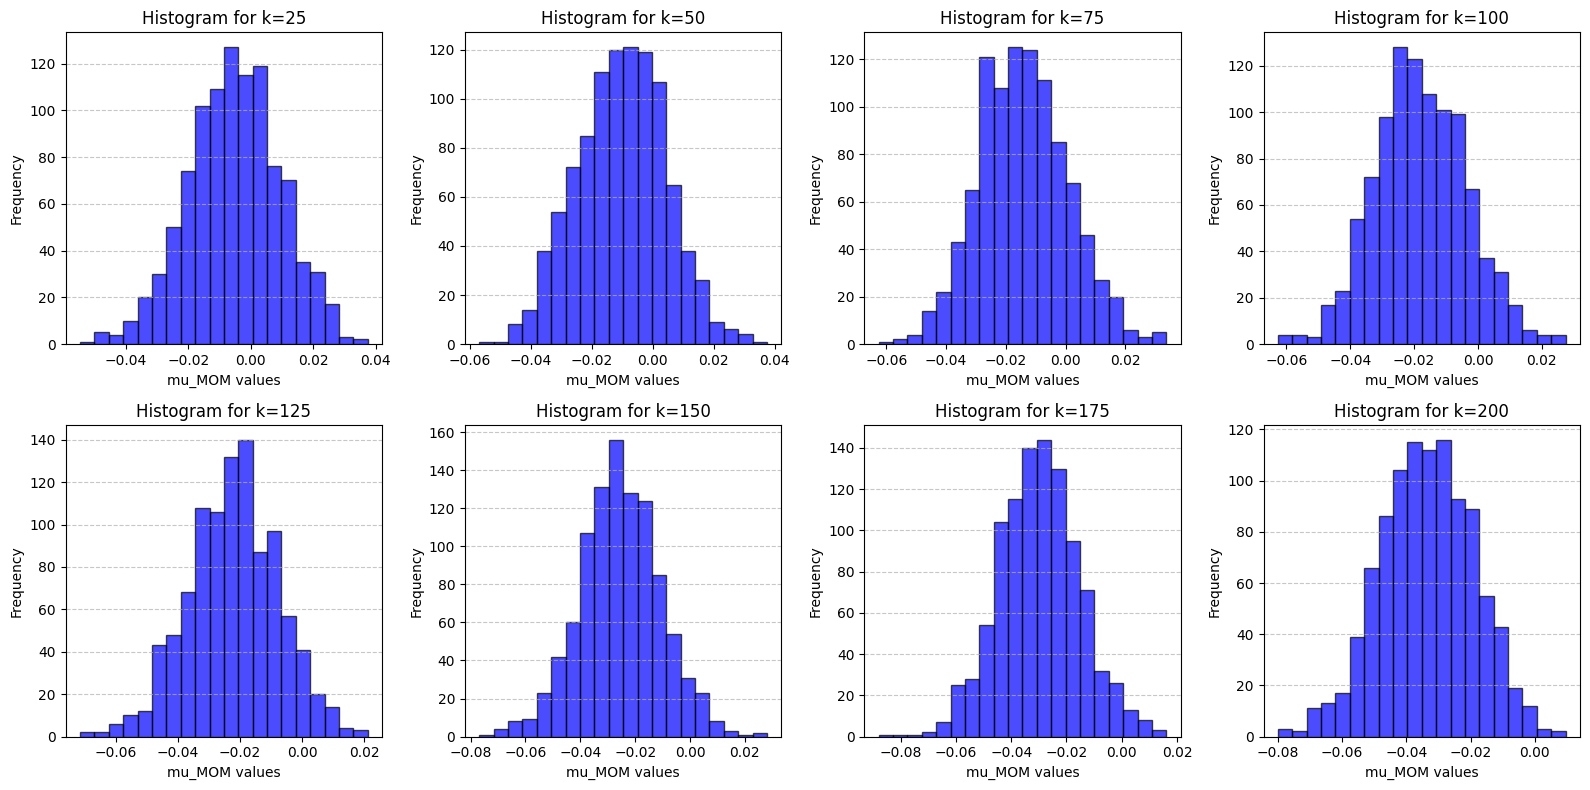

In [ ]:
bins = 20
plot_mu_MOM_hist(mu_MOM_print, O_values, k_values, simulations, bins)

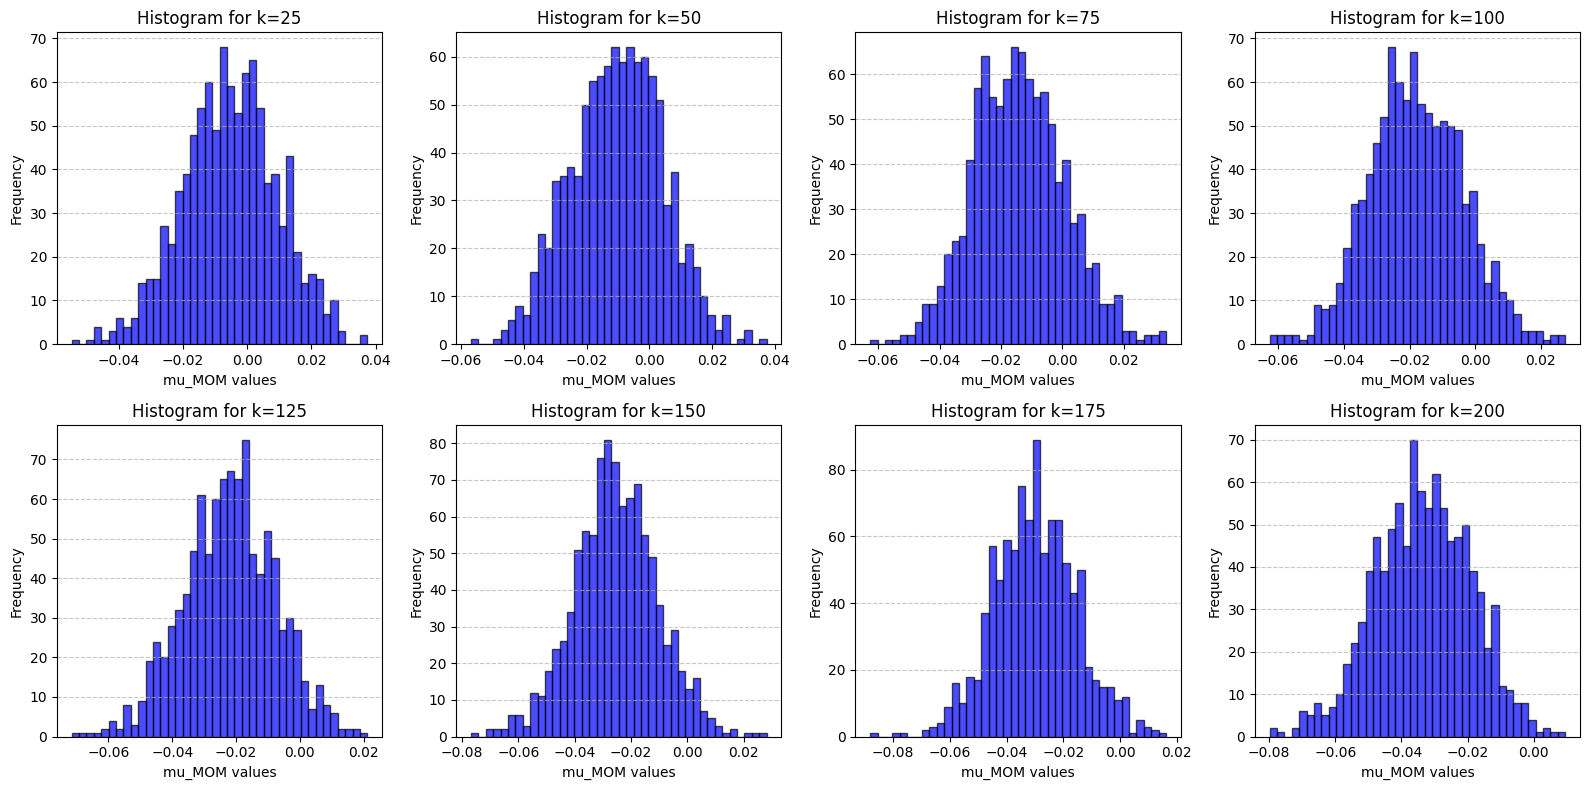

In [ ]:
bins = 40
plot_mu_MOM_hist(mu_MOM_print, O_values, k_values, simulations, bins)

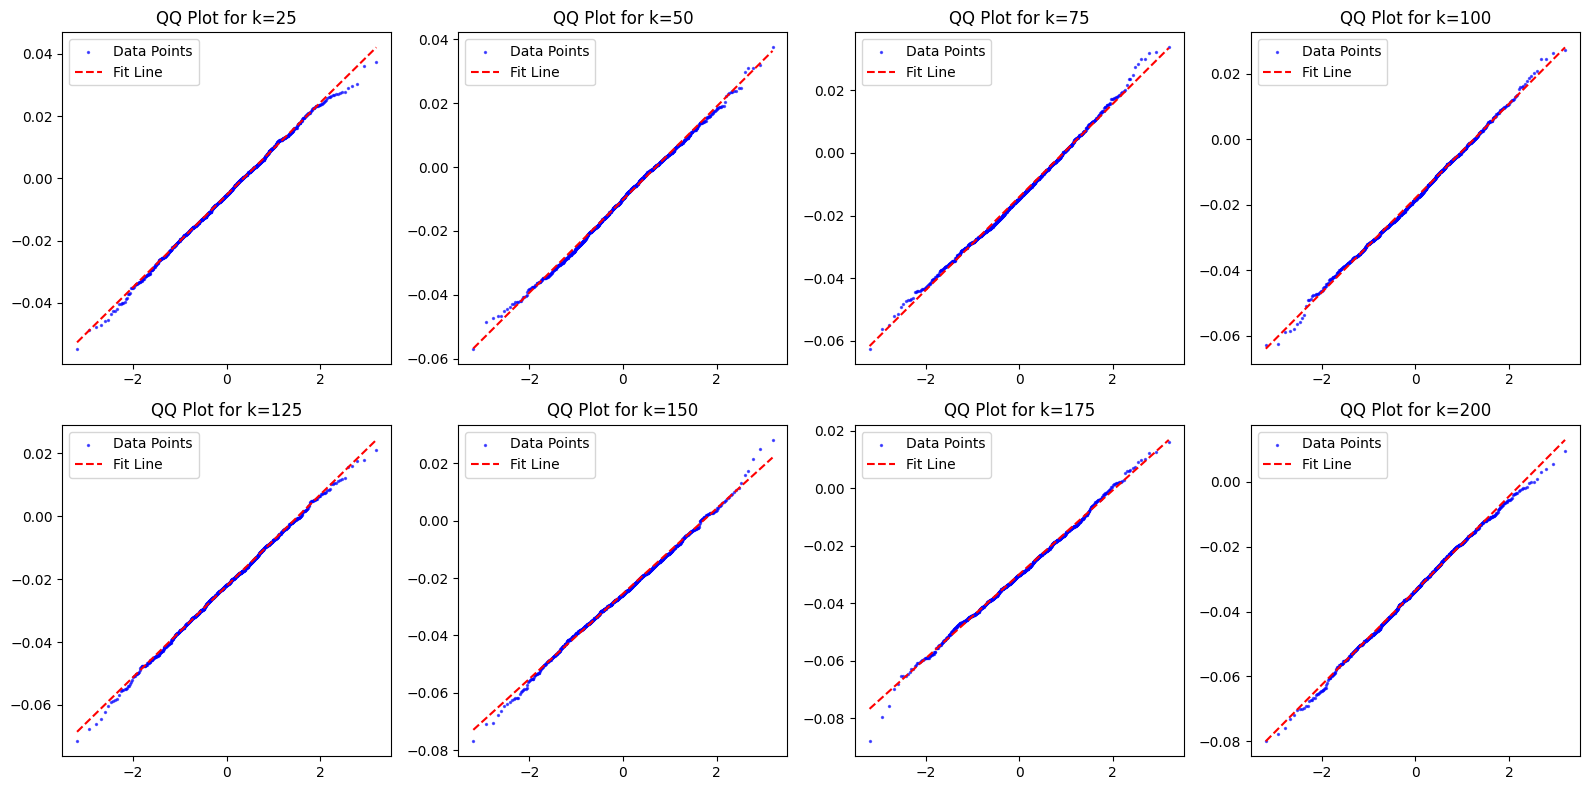

In [ ]:
plot_mu_MOM_qq(mu_MOM_print, k_values, simulations)

In [67]:
results_df = pd.DataFrame(results)
std_columns = ["mu_MOM_std", "mu_hat_N_1_std", "mu_hat_N_2_std", "mu_Trim_std"]
results_df[std_columns] = results_df[std_columns] * np.sqrt(N)
#large values were truncated to show results on appropriate scale
average_error_rules = {50: 3, 100: 3, 150: 4}
std_rules = {50: 5, 100: 5, 150: 5}
max_error_rules = {50: 5, 100: 5, 150: 5}

for estimator in ["mu_MOM_avg_error", "mu_hat_N_1_avg_error", "mu_hat_N_2_avg_error", "mu_Trim_avg_error"]:
    results_df = truncat(results_df, estimator, O_values, average_error_rules)
for estimator in ["mu_MOM_std", "mu_hat_N_1_std", "mu_hat_N_2_std", "mu_Trim_std"]:
    results_df = truncat(results_df, estimator, O_values, std_rules)
for estimator in ["mu_MOM_max_error", "mu_hat_N_1_max_error", "mu_hat_N_2_max_error", "mu_Trim_max_error"]:
    results_df = truncat(results_df, estimator, O_values, max_error_rules)

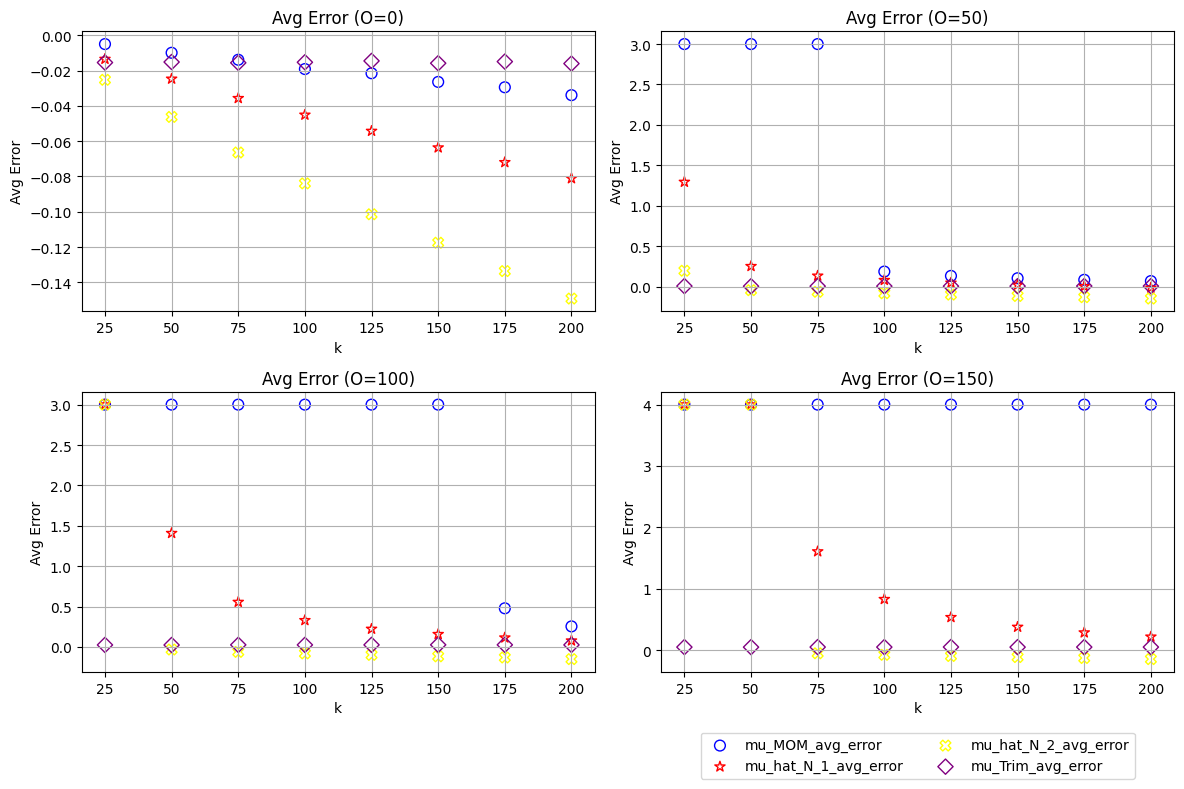

In [68]:
plots(results_df, O_values, "avg_error", estimators, "Avg Error")

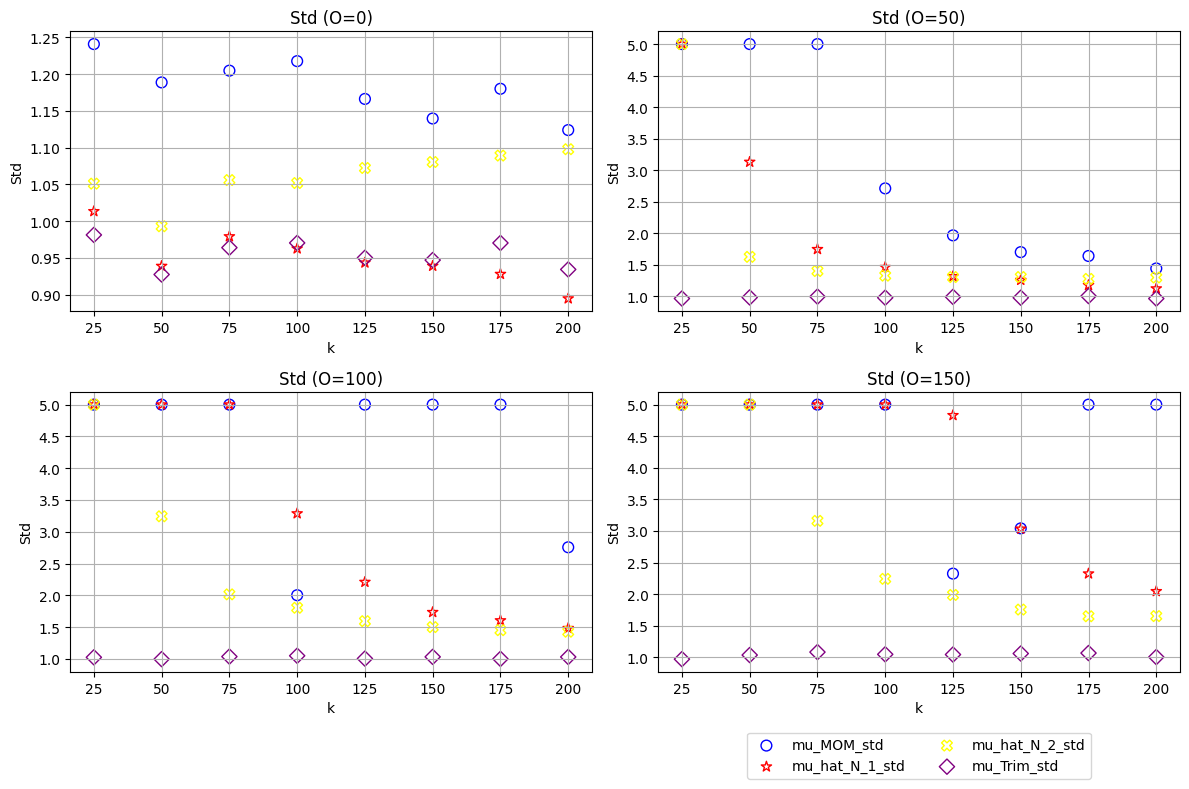

In [69]:
plots(results_df, O_values, "std", estimators, "Std")

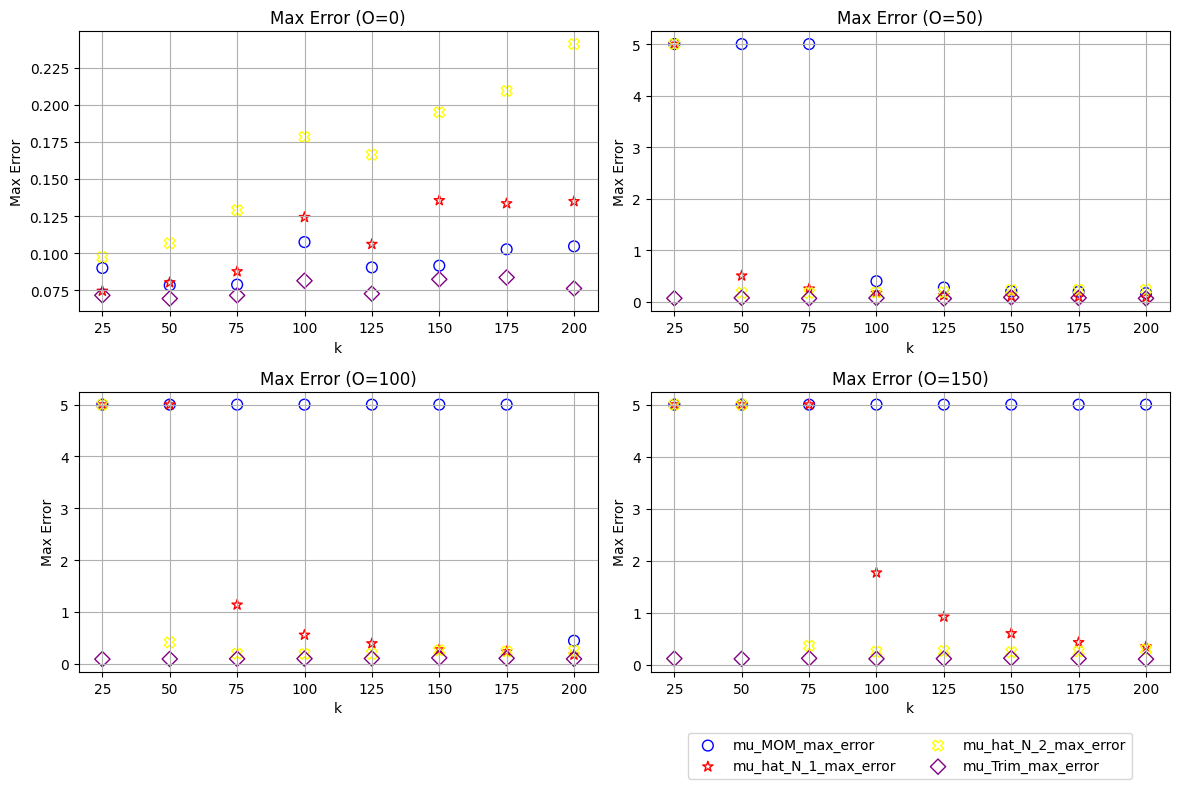

In [70]:
plots(results_df, O_values, "max_error", estimators, "Max Error")